# Import do arquivo e transformações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/Store Sales")

In [2]:
df = pd.read_csv('train.csv')

In [3]:
# Transformar a coluna de data em datetime
df['date'] = pd.to_datetime(df['date'])

# Remover 2017-08 da análise pois não é um mês completo
mask_1708 = df['date'].dt.strftime('%Y-%m').str.startswith('2017-08')
df = df[~mask_1708]

# Coluna de ano, trimestre e mês
df['ano'] = df['date'].dt.year 
df['mes'] = df['date'].dt.month 
df['trimestre'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str)).dt.to_period('Q')

# Adicionando id por grupo de ano e mês
df['yyyy_mm'] = df['ano'].astype(str) + '-' + df['mes'].astype(str)

# Transformando coluna string em int 'family'
mapeamento_valores_family = {}

for i, valor in enumerate(df['family'].unique()):
    mapeamento_valores_family[valor] = i

df['ft_family'] = df['family'].map(mapeamento_valores_family)

# Transformando coluna string em int 'trimestre'
mapeamento_valores_trimestre = {}

for i, valor in enumerate(df['trimestre'].unique()):
    mapeamento_valores_trimestre[valor] = i

df['trimestre_id'] = df['trimestre'].map(mapeamento_valores_trimestre)

# Range de datas
print("Data mínima:", df['date'].min())
print("Data máxima:", df['date'].max())

Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-07-31 00:00:00


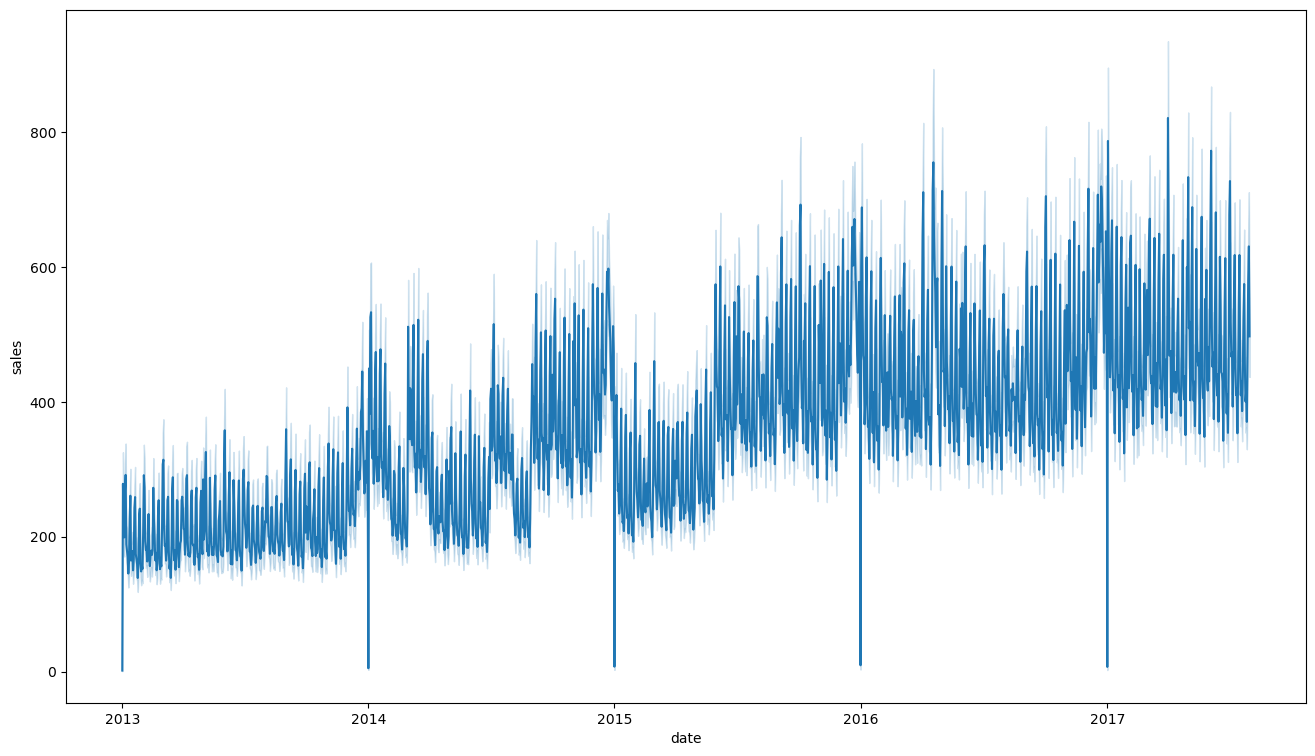

In [78]:
plt.figure(figsize = (16, 9))
sns.lineplot(x = df.date, y = df.sales)
plt.show()

In [4]:
# Renomear colunas para identificar as features ft_ e target tg_
renomear_colunas = {
    'store_nbr': 'ft_store',
    'onpromotion': 'ft_onpromotion',
    'ano': 'ft_ano',
    'mes': 'ft_mes',
    'sales': 'tg_sales'
}

df.rename(columns=renomear_colunas, inplace=True)

df.head()

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,trimestre,yyyy_mm,ft_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,2013Q1,2013-1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,2013Q1,2013-1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,2013Q1,2013-1,2
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,2013Q1,2013-1,3
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,2013Q1,2013-1,4


In [5]:
df['trimestre'].unique()

<PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3']
Length: 19, dtype: period[Q-DEC]

# Separando df de Teste

In [6]:
# Vamos separar o último trimestre para teste
df_teste = df[df['trimestre'] == '2017Q3']
df_teste.shape

(55242, 11)

In [7]:
# Separando os dados que sobraram para tv (treino e validação)
df_tv = df[df['trimestre'] != '2017Q3']
df_tv.shape

(2918916, 11)

# Holdout 70/30

In [8]:
# Agora temos que dividir o dataset em treino e validação 

df_tv['trimestre'].unique()

<PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1', '2017Q2']
Length: 18, dtype: period[Q-DEC]

In [9]:
# São 18 trimestre, sendo 70% = 12,6 
df_treino = df_tv[df_tv['trimestre'] <= '2016Q1']
df_validacao = df_tv[df_tv['trimestre'] > '2016Q1']
print('Treino:', df_treino.shape, df_treino['trimestre'].unique())
print('Validação:', df_validacao.shape, df_validacao['trimestre'].unique())

Treino: (2108106, 11) <PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1']
Length: 13, dtype: period[Q-DEC]
Validação: (810810, 11) <PeriodArray>
['2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2']
Length: 5, dtype: period[Q-DEC]


In [10]:
X_train = df_treino.filter(regex = r'ft_')
X_val = df_validacao.filter(regex = r'ft_')

y_train = df_treino['tg_sales']
y_val = df_validacao['tg_sales'] 

In [11]:
%%time

modelo = LGBMRegressor( max_depth = 5, 
                        num_leaves = 32, 
                        verbose = -1, 
                        learning_rate = 0.01, 
                        n_estimators = 1000, 
                        colsample_bytree = 0.1, 
                        random_state = 0)
modelo.fit(X_train, y_train)

CPU times: user 1min 6s, sys: 8.92 s, total: 1min 15s
Wall time: 10.7 s


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=1000, num_leaves=32, random_state=0, verbose=-1)

In [12]:
predictions = pd.Series(modelo.predict(X_val))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
correlation

0.4668603569198589

# Valor do df de Teste

In [17]:
X_test = df_teste.filter(regex = r'ft_')
y_test = df_teste['tg_sales']

predictions = pd.Series(modelo.predict(X_test))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_test, ranked_predictions)[0, 1]
correlation

0.49104906486447286